*This notebook plots the private network latency contribution as a ratio of hop1 to hop2 latencies.*
- - - 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
import sqlite3
import pandas as pd

In [5]:
DB_LOCATION = 'lastmile.db'

In [6]:
RA_PROBE = 'ra_probe'
RA_PROBE_API = 'ra_probe_api'
RA_ASN = 'ra_asn'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [7]:
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_LATENCIES_AGG = 'sk_latencies_agg'
SK_ASN = 'sk_asn'
METADATA_SNAPSHOT = 'metadata_snapshot'
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'

In [8]:
con = sqlite3.connect(DB_LOCATION)

In [9]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , s.asn
                        , s.asn_holder_name
                        , agg.h1_median as h1
                        , agg.h2_median as h2
                        , agg.h1_median || ';' || agg.h2_median as h1h2
                        

               FROM   %s                             as  agg
                    , %s                             as  api               
                    , %s                             as  s                  
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       api.asn_v4                   =  s.asn
               

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1
               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE_API
                 , RA_ASN
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [10]:
df_ra.count()

probeid            134724
timestamp          134724
asn                134724
asn_holder_name    134724
h1                 133920
h2                 130563
h1h2               130006
dtype: int64

In [11]:
df_ra.head()

,probeid,timestamp,asn,asn_holder_name,h1,h2,h1h2
0,10006,1406548034,3265,"XS4ALL-NL XS4ALL Internet BV,NL",0.429,20.490,0.429;20.49
1,10006,1406562432,3265,"XS4ALL-NL XS4ALL Internet BV,NL",0.431,17.700,0.431;17.7
2,10006,1406576835,3265,"XS4ALL-NL XS4ALL Internet BV,NL",0.438,17.776,0.438;17.776
3,10006,1406591230,3265,"XS4ALL-NL XS4ALL Internet BV,NL",0.478,17.577,0.478;17.577
4,10006,1406605631,3265,"XS4ALL-NL XS4ALL Internet BV,NL",0.422,17.526,0.422;17.526


In [12]:
query_sk = ''' SELECT     agg.probeid
                        , agg.timestamp
                        , s.asn       
                        , s.asn_holder_name
                        , meta.product                        
                        , agg.h1_avg as h1
                        , agg.h2_avg as h2
                        , agg.h1_avg || ';' || agg.h2_avg as h1h2


                                                                                     
               FROM       %s                            as   agg
                        , %s                            as   api               
                        , %s                            as   ext
                        , %s                            as   s
                        , %s                            as   meta
                        
                        

               WHERE      agg.probeid                    =    ext.probeid
               AND        agg.probeid                    =    api.probeid
               AND        agg.probeid                    =    meta.id               
               AND        api.asn                        =    s.asn               
               
               AND        ext.if_residential             =    1
               AND        agg.h1_avg                     <>   0
               AND        agg.h2_avg                     <>   0
               
           '''%(   SK_LATENCIES_AGG
                 , METADATA_SNAPSHOT_EXTENSIONS                
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_ASN        
                 , METADATA_SNAPSHOT                
               )

df_sk = pd.read_sql(query_sk, con)

In [13]:
df_ra = df_ra.dropna()

In [14]:
df_sk = df_sk.dropna()

In [15]:
df_sk.count()

probeid            435841
timestamp          435841
asn                435841
asn_holder_name    435841
product            435841
h1                 435841
h2                 435841
h1h2               435841
dtype: int64

In [16]:
df_ra.count()

probeid            130006
timestamp          130006
asn                130006
asn_holder_name    130006
h1                 130006
h2                 130006
h1h2               130006
dtype: int64

In [17]:
def calculate_private_contribution(h1h2):
    try: h1,h2 = h1h2.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: contribution = float(h1)/float(h2) *100
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return contribution

In [18]:
df_ra['private_contribution'] = df_ra['h1h2'].apply(calculate_private_contribution)
df_sk['private_contribution'] = df_sk['h1h2'].apply(calculate_private_contribution)

In [19]:
df_ra_groupby = df_ra.groupby('probeid')
df_ra_agg = df_ra_groupby['h1', 'h2', 'private_contribution'].agg(['median'])
df_ra_merged = pd.merge(df_ra, df_ra_agg, left_on='probeid', right_index=True)

del df_ra_merged['timestamp']
del df_ra_merged['h1']; del df_ra_merged['h2']
del df_ra_merged['h1h2']
del df_ra_merged['private_contribution']

df_ra_merged = df_ra_merged.drop_duplicates()
df_ra_merged.rename(columns={ df_ra_merged.columns[3]: 'h1_median'
                             ,df_ra_merged.columns[4]: 'h2_median'
                             ,df_ra_merged.columns[5]: 'private_contribution'
                            }, inplace=True)

In [20]:
df_sk_groupby = df_sk.groupby('probeid')
df_sk_agg = df_sk_groupby['h1', 'h2', 'private_contribution'].agg(['median'])
df_sk_merged = pd.merge(df_sk, df_sk_agg, left_on='probeid', right_index=True)

del df_sk_merged['timestamp']
del df_sk_merged['h1']; del df_sk_merged['h2']
del df_sk_merged['h1h2']
del df_sk_merged['private_contribution']

In [21]:
df_sk_merged = df_sk_merged.drop_duplicates()
df_sk_merged.rename(columns={  df_sk_merged.columns[4]: 'h1_median'                             
                             , df_sk_merged.columns[5]: 'h2_median'
                             , df_sk_merged.columns[6]: 'private_contribution'

                            }, inplace=True)

In [22]:
df_ra_merged.count()

probeid                 691
asn                     691
asn_holder_name         691
h1_median               691
h2_median               691
private_contribution    691
dtype: int64

In [23]:
df_sk_merged.count()

probeid                 1245
asn                     1245
asn_holder_name         1245
product                 1245
h1_median               1245
h2_median               1245
private_contribution    1245
dtype: int64

In [24]:
import Cdf
import Pmf

ra_h1_sample = df_ra_merged.sort('h1_median')['h1_median'].values
ra_h2_sample = df_ra_merged.sort('h2_median')['h2_median'].values
sk_h1_sample = df_sk_merged.sort('h1_median')['h1_median'].values
sk_h2_sample = df_sk_merged.sort('h2_median')['h2_median'].values

ra_h1_c = Cdf.MakeCdfFromList(ra_h1_sample)
ra_h2_c = Cdf.MakeCdfFromList(ra_h2_sample)
sk_h1_c = Cdf.MakeCdfFromList(sk_h1_sample)
sk_h2_c = Cdf.MakeCdfFromList(sk_h2_sample)

In [25]:
df_ra_merged.count()

probeid                 691
asn                     691
asn_holder_name         691
h1_median               691
h2_median               691
private_contribution    691
dtype: int64

In [26]:
np.arange(50,110,25)

array([ 50,  75, 100])

In [27]:
ra_h1_c.xs[-1]

89.730999999999995

In [28]:
total = df_ra_merged['probeid'].count()
c1 = df_ra_merged[df_ra_merged.h1_median <= 1]['probeid'].count()
c2 = df_ra_merged[df_ra_merged.h1_median > 1][df_ra_merged.h1_median <= 20]['probeid'].count()
c3 = df_ra_merged[df_ra_merged.h1_median > 20]['probeid'].count()

percent1 = float(c1)/total * 100
print('RIPE Atlas; [0, 1] ms; %0.2f%%; %d/%d'%(percent1, c1, total))

percent2 = float(c2)/total * 100
print('RIPE Atlas; (1, 20] ms; %0.2f%%; %d/%d'%(percent2, c2, total))

percent3 = float(c3)/total * 100
print('RIPE Atlas; (20, _) ms; %0.2f%%; %d/%d'%(percent3, c3, total))

print('total: %f'%(percent1 + percent2 + percent3))

RIPE Atlas; [0, 1] ms; 92.47%; 639/691
RIPE Atlas; (1, 20] ms; 7.09%; 49/691
RIPE Atlas; (20, _) ms; 0.43%; 3/691
total: 100.000000


In [29]:
np.arange(100,301,100)

array([100, 200, 300])

In [30]:
sk_h2_c.xs[-1]

250.92500000000001

In [31]:
df_sk_merged[df_sk_merged.h1_median > 30][df_sk_merged.private_contribution < 100]

,probeid,asn,asn_holder_name,product,h1_median,h2_median,private_contribution
45233,140864,6871,"PLUSNET PlusNet PLC,GB",20,50.7525,47.6725,98.229535
88488,142024,6871,"PLUSNET PlusNet PLC,GB",20,48.5505,63.6645,91.211900
89699,142036,6871,"PLUSNET PlusNet PLC,GB",8,50.4685,49.7155,96.026989
135978,143580,6871,"PLUSNET PlusNet PLC,GB",8,54.0135,56.8900,88.264341


In [32]:
total = df_sk_merged['probeid'].count()
c1 = df_sk_merged[df_sk_merged.h1_median <= 1.5]['probeid'].count()
c2 = df_sk_merged[df_sk_merged.h1_median > 1.5][df_sk_merged.h1_median <= 30]['probeid'].count()
c3 = df_sk_merged[df_sk_merged.h1_median > 30]['probeid'].count()

percent1 = float(c1)/total * 100
print('SamKnows; [0, 1.5] ms; %0.2f%%; %d/%d'%(percent1, c1, total))

percent2 = float(c2)/total * 100
print('SamKnows; (1.5, 30] ms; %0.2f%%; %d/%d'%(percent2, c2, total))

percent3 = float(c3)/total * 100
print('SamKnows; (30, _) ms; %0.2f%%; %d/%d'%(percent3, c3, total))

print('total: %f'%(percent1 + percent2 + percent3))

SamKnows; [0, 1.5] ms; 79.68%; 992/1245
SamKnows; (1.5, 30] ms; 10.20%; 127/1245
SamKnows; (30, _) ms; 10.12%; 126/1245
total: 100.000000


In [33]:
df_ra_merged_rate = df_ra_merged[df_ra_merged.private_contribution > 100]
df_sk_merged_rate = df_sk_merged[df_sk_merged.private_contribution > 100]

ra_percent = df_ra_merged_rate['probeid'].count()/df_ra_merged['probeid'].count() * 100
sk_percent = df_sk_merged_rate['probeid'].count()/df_sk_merged['probeid'].count() * 100

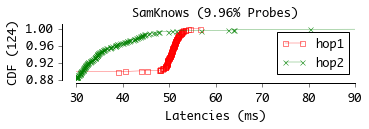

In [34]:
# ------ plt.style.use('ggplot')
fig = plt.figure(figsize=(5,1))
plt.rcParams['font.size'] = 12
yticks = np.arange(0.88,1.02,0.04)
ax = plt.gca()

ax.plot (  sk_h1_c.xs
          , sk_h1_c.ps
          , marker='s'
          , linewidth=0.3
          , markersize=5
          , fillstyle='none'
          , color='Red'
         )

ax.plot (  sk_h2_c.xs
          , sk_h2_c.ps
          , marker='x'
          , linewidth=0.3
          , markersize=5
          , fillstyle='none'
          , color='Green'
         )

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_ylim([0.88,1.01])
ax.set_xlim([30, 90])
ax.set_xscale('linear')
ax.set_xlabel('Latencies (ms)', fontsize=12)
ax.set_ylabel('CDF (%d Probes)'%df_sk_merged_rate['probeid'].count(), fontsize=12)
ax.set_ylabel('CDF (%d)'%df_sk_merged_rate['probeid'].count(), fontsize=12)
ax.legend([  'hop1', 'hop2'%df_ra_merged_rate['probeid'].count()
          ], fontsize=12, loc='lower right')
plt.title('SamKnows (%0.2f%% Probes)'%sk_percent, fontsize=12, y=1.05)
plt.savefig('samknows-h1-h2-icmp-rate-limits.pdf', format='pdf', bbox_inches='tight')